# FINAL NPxZxD PROTOTYPE

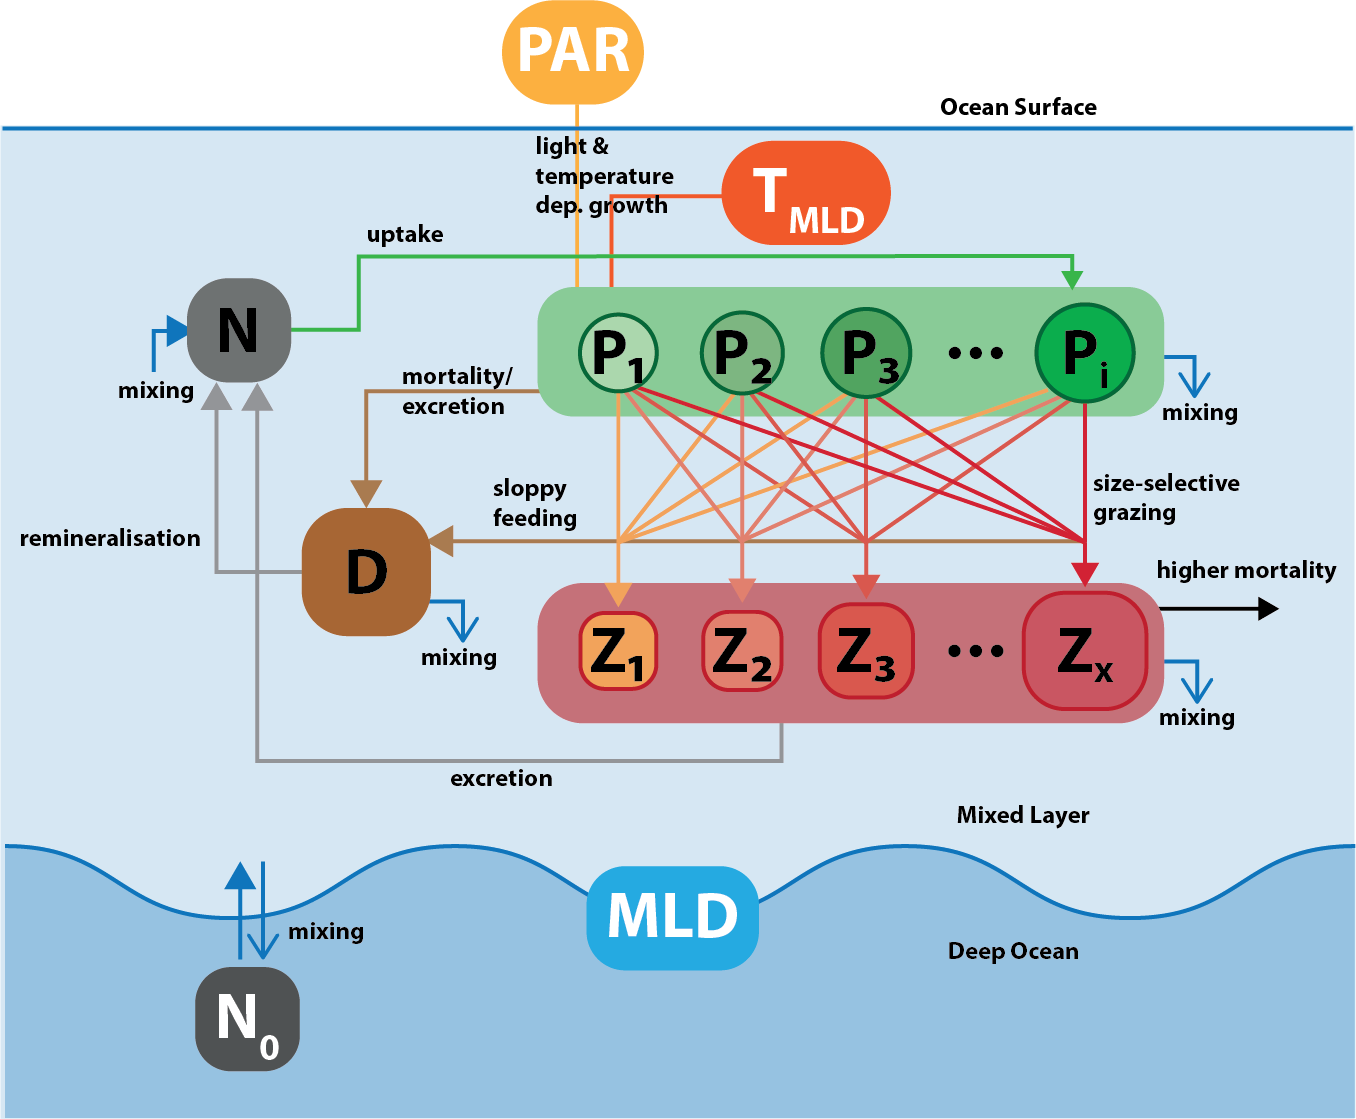

In [1]:
from IPython.display import Image
Image(filename=('NPxZxDslab_schematics.png'), width=500)

In [2]:
import numpy as np
# to check for array handling errors:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

# Parameter helping functions

In [3]:
def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

In [4]:
calculate_sizes(2,200,20)

array([  2.        ,   2.54854997,   3.24755348,   4.13827616,
         5.2733018 ,   6.71963657,   8.5626648 ,  10.91118956,
        13.90385592,  17.71733581,  22.57675783,  28.76899777,
        36.65961422,  46.71442938,  59.52702883,  75.85380381,
        96.65860477, 123.16964221, 156.95199407, 200.        ])

In [5]:
def initialize_alloparams(self):
    """initializes allometric parameters based on array of sizes (ESD)"""
    self.I0 = 26 * (self.size) ** -0.4 #* .5
    self.xpreyopt = 0.65 * (self.size) ** .56 # which should equal = self.phytosize

def initialize_alloparams(self):
    """initializes allometric parameters based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    self.mu0 = 2.6 * (self.size) ** -0.45
    self.ks = (self.size) * .1

In [6]:
import numpy as np

In [7]:
phytosize = calculate_sizes(2,200,3)
xpreyopt = phytosize # calculate_sizes(20,400,3)


def init_phiP():
    """creates array of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in xpreyopt])
    return phiP

phiP = init_phiP()
phiP

array([[1.00000000e+00, 1.12535175e-07, 1.60381089e-28],
       [1.12535175e-07, 1.00000000e+00, 1.12535175e-07],
       [1.60381089e-28, 1.12535175e-07, 1.00000000e+00]])

In [ ]:
ax = np.array([[1,2,3],[4,5,6],[7,8,9]])

yx = np.vstack(np.array([0.4, 0.5, 6]))

qx = np.array([0.1, 0.2, 0.3])


In [ ]:
resource = np.array([0.15,2.2,0.3])
consumer = np.array([5.01,0.02,0.09])

Imax = 1
KsZ = 0.5

def grazing(resource, consumer, phiP, Imax, KsZ):
    # print("GRAZING mat calc", resource, consumer, phiP, Imax, KsZ)
    PscaledAsFood = phiP / KsZ * np.vstack(resource)
    print("PscaledAsFood", np.shape(PscaledAsFood), PscaledAsFood)
    FgrazP = Imax * consumer * PscaledAsFood / (1 + np.sum(PscaledAsFood, axis=0))
    # print("FgrazP", FgrazP, type(FgrazP))
    return FgrazP

In [ ]:
def _grazingmatrix(P, Z):
    PscaledAsFood = np.zeros((np.size(P), np.size(Z)))
    for j in range(np.size(Z)):
        for i in range(np.size(P)):
            PscaledAsFood[i, j] = phiP[i, j] / 0.1 * P[i]
            
    print("PscaledAsFood", PscaledAsFood)
    
    FgrazP = np.zeros((np.size(P), np.size(Z)))
    for j in range(np.size(Z)):
        for i in range(np.size(P)):
            FgrazP[i, j] = 0.1 * Z[j] * PscaledAsFood[i, j] / (1 + sum(PscaledAsFood[:, j]))
    
    return FgrazP

In [ ]:
graze1 = grazing(yx, qx, phiP, 0.1, 0.1)
graze1

In [ ]:
graze2 = _grazingmatrix(yx,qx)
graze2

In [ ]:
graze1 - graze2

In [ ]:
np.sum(graze1, axis=0)

In [ ]:
np.sum(graze1, axis=1)

In [ ]:
np.sum(graze2, axis=0)

In [ ]:
np.sum(graze2, axis=1)

In [ ]:
def _ingestion(FgrazP):
        return [sum(FgrazP[:,j]) for j in range(3)]

In [ ]:
def _grazed(FgrazP):
        return [sum(FgrazP[i,:]) for i in range(3)]

In [ ]:
ingest1 = _ingestion(graze1)
ingest2 = np.sum(graze1, axis=0)
grazed1 = _grazed(graze1)
grazed2 = np.sum(graze1, axis=1)

print(ingest1-ingest2)
print(grazed1-grazed2)

In [ ]:
np.sum(PscaledAsFood, axis=0)

In [ ]:
np.sum(PscaledAsFood, axis=1)

# Model building

In [8]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [9]:
from phydra.components.variables import SV, SVArray

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.basic_dims import (LinearDecay_Dim, LinearExchange_SourceDim, 
                                                 QuadraticDecay_Dim, QuadraticExchange_SourceDim)
from phydra.components.fluxes.growth_multi_lim import (Growth_ML_ConsumerDim, Eppley_ML_ConsumerDim, 
                                                       Monod_ML_ConsumerDim, Steele_ML_ConsumerDim)
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              SizebasedGrazingKernel_Dims,
                                              GrossGrowthEfficiency_MatrixGrazing,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import SlabUpwelling, SlabMixing, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing

In [10]:
NPxZxD = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SVArray,
    'Zooplankton':SVArray,
    'Detritus':SV,
    
    # Mixing:
    'Upwelling':SlabUpwelling,
    'Mixing':SlabMixing,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML_ConsumerDim,
    'Monod':Monod_ML_ConsumerDim,
    'Steele':Steele_ML_ConsumerDim,
    'Eppley':Eppley_ML_ConsumerDim,
    
    # Grazing
    'Grazing':SizebasedGrazingKernel_Dims,
    'GGE':GrossGrowthEfficiency_MatrixGrazing,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange_SourceDim,
    'PhytoQuadMortality':QuadraticExchange_SourceDim,
    'ZooLinMortality':LinearExchange_SourceDim,
    'HigherOrderPred':QuadraticDecay_Dim,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

In [11]:
#NPxZxD.visualize()

In [12]:
NPxZxD

<xsimlab.Model (26 processes, 99 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_init                 [in] ('var',) initial value / basic st...
    var_label                [in] label / basic state variable
Zooplankton
    var_init                 [in] ('var',) initial value / basic st...
    var_label                [in] label / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Tmld
    forcing_label            [in] label / 
    lon                      [in] constant value of forcing
    k                        [in] The degree of the spline fit
    deriv                    [in] order of derivative to store, for...
    lat              

In [13]:
# Set common location of global slab forcing
forcing_location = {'lat':47,'lon':-20,'rbb':2}

odeint_setup = phydra.setup('odeint', NPxZxD,
            time=np.arange(0,365*5),  # *365
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':[.2,.2,.2]},
                    'Zooplankton':{'var_label':'Z','var_init':[.1,.1,.1]},
                    'Detritus':{'var_label':'D','var_init':1.},
                
                    # Mixing:
                    'Upwelling':{'n':'N', 'n_0':'N0', 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Mixing':{'vars_sink':['P','D'], 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Monod':{'resource':'N', 'halfsat':[.81, .83, .85]},
                    'Steele':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'i_opt':10},
                    'Eppley':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'Imax':[.1,.1,.1], 'KsZ':[0.6,0.6,0.6], 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'D', 
                           'epsilon':0.33, 'f_eg':0.33},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.1},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.01},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.01},
                    'HigherOrderPred':{'var':'Z', 'rate':0.034},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.1},

                    # Forcings
                    'N0':{**forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

In [14]:
gekko_setup = phydra.update_setup(model=NPxZxD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [15]:
with NPxZxD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
CALCULATING FLUX Time_time_flux None
Time_time_flux 1 <class 'int'> None
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Tmld
Initializing component N0
Initializing component MLDderiv
Initializing component MLD
Initializing component I0
Initializing component Upwelling
CALCULATING FLUX Upwelling_mixing ()
None
INPUT ARGS: {'n': 1.0, 'kappa': 0.13, 'n_0': [5.08990988 5.13285976 5.1751093  ... 4.95943891 5.00305608 5.04654641], 'mld': [160.42073947 162.21964143 163.98088737 ... 155.01841292 156.80788547
 158.60866099], 'mld_deriv': [1.81772996 1.78007395 1.74241794 ... 1.78382107 1.79512403 1.806427  ]}
args vec excl ['n', 'n_0', 'mld', 'mld_deriv']
Upwelling_mixing (((((n0-n))*((p38+upwelling_kappa))))/(mld)) <class 'numpy.ndarray'> ()
Initializing component Mixing
CALCULATING FLUX Mixing_mixing sinking_vars_full
sinking_vars
I

ValueError: need at least one array to concatenate

In [14]:
# odeint_setup

In [15]:
with NPxZxD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
FULL DIMS (1825,)
variable time (1825,)
FULL DIMS (1825,)
flux Time_time_flux (1825,)
Initializing component Nutrient
FULL DIMS (1825,)
variable N (1825,)
Initializing component Phytoplankton
FULL DIMS (3, 1825)
variable P (3, 1825)
Initializing component Zooplankton
FULL DIMS (3, 1825)
variable Z (3, 1825)
Initializing component Detritus
FULL DIMS (1825,)
variable D (1825,)
Initializing component Tmld
Initializing component N0
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component Upwelling
FULL DIMS (1825,)
flux Upwelling_mixing (1825,)
Initializing component Mixing
FULL DIMS (4, 1825)
flux Mixing_mixing (4, 1825)
Initializing component Sinking
FULL DIMS (1825,)
flux Sinking_sinking (1825,)
Initializing component Grazing
FULL DIMS (3, 3, 1825)
flux Grazing_grazing (3, 3, 1825)
Initializing component Monod
FULL DIMS (3, 1825)
flux Monod_monod_lim (3, 1825)
Initializing component Det

In [17]:
odeint_out

<xarray.Dataset>
Dimensions:                           (clock: 2, consumer: 3, input_time: 1825, resource: 3, sinking_vars: 2, sinking_vars_full: 4, time: 1825, var: 3, vars: 3)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: consumer, input_time, resource, sinking_vars, sinking_vars_full, time, var, vars
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.1 0.09602 ... 0.04752
    DetRemineralisation__rate         float64 0.1
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 1.0
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (time) float64 1.0 0.9232 ... 0.4781
    Eppley__eppley_exp                float64 0.063
    Eppley__eppley_growth_label       <U20 'Eppley_eppley_growth'
    Eppley__eppley_growth_value       (time) float64 2.32 2.318 ... 2.333 2.328
    Eppley__temp                      <U4 'Tmld'
    GGE__assimilated_consumer         <U1 'Z'
    GGE__assimilation_value           (consumer, time) float64 0.000825 ... 2...
    GGE__egested_detritus             <U1 'D'
    GGE__egestion_value               (time) float64 0.00255 ... 2.992e-05
    GGE__epsilon                      float64 0.33
    GGE__f_eg                         float64 0.33
    GGE__grazed_resource              <U1 'P'
    GGE__grazing_value                (resource, time) float64 0.0025 ... 6.7...
    Grazing__Imax                     (consumer) float64 0.1 0.1 0.1
    Grazing__KsZ                      (consumer) float64 0.6 0.6 0.6
    Grazing__consumer                 <U1 'Z'
    Grazing__grazing_label            <U15 'Grazing_grazing'
    Grazing__grazing_value            (resource, consumer, time) float64 0.00...
    Grazing__phiP                     (resource, consumer) float64 1.0 ... 1.0
    Grazing__resource                 <U1 'P'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (vars, time) float64 0.03959 ... 0.001741
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (var, time) float64 0.00034 ... 2.776e-17
    HigherOrderPred__rate             float64 0.034
    HigherOrderPred__var              <U1 'Z'
    I0__dataset                       <U3 'par'
    I0__deriv                         int64 0
    I0__forcing_label                 <U2 'I0'
    I0__forcing_value                 (time) float64 7.521 7.594 ... 7.388 7.452
    I0__k                             int64 2
    I0__lat                           int64 47
    I0__lon                           int64 -20
    I0__rbb                           int64 2
    I0__smooth                        int64 10
    MLD__dataset                      <U3 'mld'
    MLD__deriv                        int64 0
    MLD__forcing_label                <U3 'MLD'
    MLD__forcing_value                (time) float64 160.4 162.2 ... 156.8 158.6
    MLD__k                            int64 2
    MLD__lat                          int64 47
    MLD__lon                          int64 -20
    MLD__rbb                          int64 2
    MLD__smooth                       int64 400
    MLDderiv__dataset                 <U3 'mld'
    MLDderiv__deriv                   int64 1
    MLDderiv__forcing_label           <U8 'MLDderiv'
    MLDderiv__forcing_value           (time) float64 1.818 1.78 ... 1.795 1.806
    MLDderiv__k                       int64 2
    MLDderiv__lat                     int64 47
    MLDderiv__lon                     int64 -20
    MLDderiv__rbb                     int64 2
    MLDderiv__smooth                  int64 400
    Mixing__kappa                     float64 0.13
    Mixing__mixing_value              (sinking_vars_full, time) float64 0.002...
    Mixing__mld                       <U3 'MLD'
    Mixing__mld_deriv                 <U8 'MLDderiv'

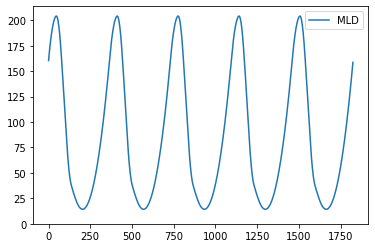

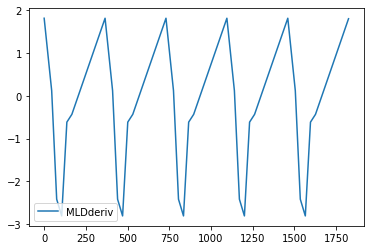

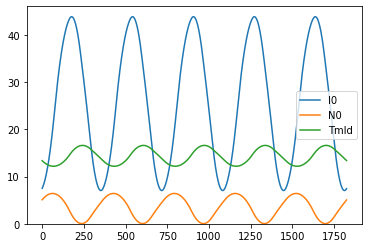

In [18]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

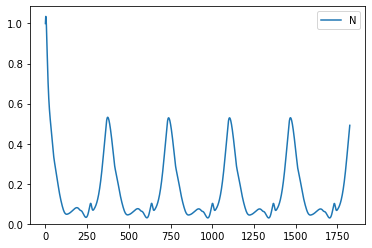

In [19]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

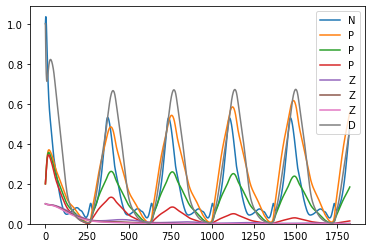

In [20]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

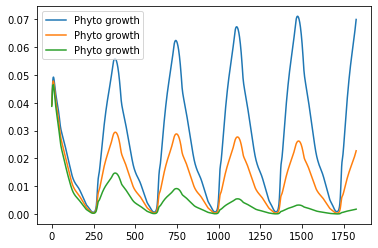

In [21]:
#plt.plot(time, -odeint_out.PhytoLinMortality__decay_value.T, label='P linear mortality')
#plt.plot(time, -odeint_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, odeint_out.Growth__growth_value.T, label='Phyto growth')

plt.legend()

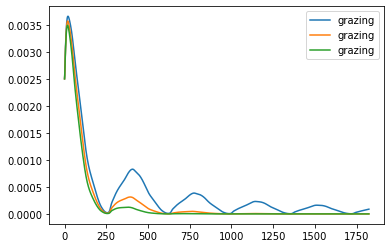

In [22]:
plt.plot(time, odeint_out.GGE__grazing_value.T, label="grazing")
plt.legend()

In [23]:
stepwise_setup = phydra.update_setup(model=NPxZxD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,5*365,.2))

In [24]:
with NPxZxD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Tmld
Initializing component N0
Initializing component MLD
Initializing component I0
Initializing component MLDderiv
Initializing component Upwelling
Initializing component Mixing
Initializing component Sinking
Initializing component Grazing
Initializing component Monod
Initializing component DetRemineralisation
Initializing component Eppley
Initializing component PhytoLinMortality
Initializing component HigherOrderPred
Initializing component ZooLinMortality
Initializing component Steele
Initializing component PhytoQuadMortality
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x15905bac0>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['Tmld_dataset', 'Tmld_

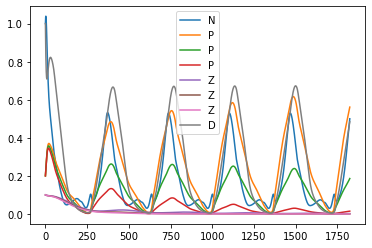

In [25]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
#plt.ylim(bottom=0)
plt.legend()

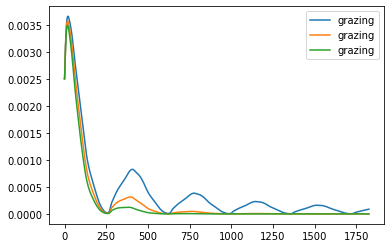

In [26]:
plt.plot(time, stepwise_out.GGE__grazing_value.T, label="grazing")
plt.legend()

#stepwise_out.GGE__egestion_value

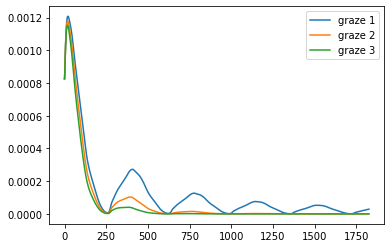

In [27]:
plt.plot(time, stepwise_out.GGE__assimilation_value[0,:], label="graze 1")
plt.plot(time, stepwise_out.GGE__assimilation_value[1,:], label="graze 2")
plt.plot(time, stepwise_out.GGE__assimilation_value[2,:], label="graze 3")
plt.legend()

In [29]:
#plt.plot(time, stepwise_out.GGE__grazed_resource)

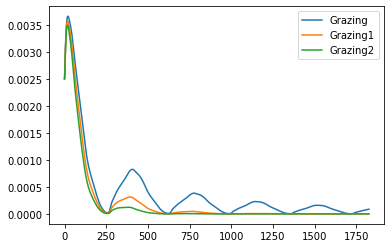

In [30]:
# plt.plot(time, stepwise_out.Input__input_value, label='N_input')
# plt.plot(time, -stepwise_out.PhytoLinMortality__decay_value, label='P mortality')
# plt.plot(time, -stepwise_out.PhytoQuadMortality__decay_value, label='P quad mortality')
# plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value[0,0,:], label='Grazing')
plt.plot(time, stepwise_out.Grazing__grazing_value[1,1,:], label='Grazing1')
plt.plot(time, stepwise_out.Grazing__grazing_value[2,2,:], label='Grazing2')
# plt.ylim(bottom=0)
plt.legend()

In [15]:
gekko_setup = phydra.update_setup(model=NPxZxD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [16]:
with NPxZxD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
CALCULATING FLUX Time_time_flux None
Time_time_flux 1 <class 'int'> None
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Tmld
Initializing component MLDderiv
Initializing component MLD
Initializing component I0
Initializing component N0
Initializing component Upwelling
CALCULATING FLUX Upwelling_mixing ()
Upwelling_mixing (((((n0-n))*((p38+upwelling_kappa))))/(mld)) <class 'numpy.ndarray'> ()
Initializing component Mixing
CALCULATING FLUX Mixing_mixing sinking_vars_full
Mixing_mixing [((((p0)*((p41+mixing_kappa))))/(mld))
 ((((p1)*((p42+mixing_kappa))))/(mld))
 ((((p2)*((p43+mixing_kappa))))/(mld))
 ((((d)*((p44+mixing_kappa))))/(mld))] <class 'numpy.ndarray'> sinking_vars_full
Initializing component Sinking
CALCULATING FLUX xSinking_sinking ()
xSinking_sinking ((((d)*(xsinking_rate)))/(mld)) <class 'numpy.ndarray'> ()
Initial

ValueError: need at least one array to concatenate

In [ ]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(time, gekko_out.PhytoLinMortality__decay_value.T, label='P mortality')
plt.plot(time, gekko_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, gekko_out.Growth__growth_value.T, label='N uptake')
#plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()